<div style="line-height:0.5">
<h1 style="color:#0FA345 "> Support Vector Machines for Classification 2 </h1>
<h4> Implementation of SVM using cvxopt package. </h4>
<div style="margin-top: -12px;">
<span style="display: inline-block;">
    <h3 style="color: lightblue; display: inline;">Keywords:</h3> cvxopt + kernels
</span>
</div>

In [1]:
import cvxopt
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def create_dataset(N, D=2, K=2):
    """ Generate a synthetic dataset with two classes.

    Parameters:
        - Number of samples per class [int].
        - Number of features (default: 2) [int].
        - Number of classes (default: 2) [int].

    Returns:
        - X: Array of shape (N * K, D) containing the feature vectors [ndarray]
        - y: Array of shape (N * K,) containing the corresponding class labels [ndarray]

    """    
    X = np.zeros((N * K, D))  
    y = np.zeros(N * K)

    # Generate samples for the K class, assigns them to the appropriate indices in X and y
    for j in range(K):
        # Calculate the indices ix that correspond to the range of indices in X and y to assign the samples for that class.
        ix = range(N * j, N * (j + 1))
        r = np.linspace(0.0, 1, N)  # radius
        t = np.linspace(j * 4, (j + 1) * 4, N) + np.random.randn(N) * 0.2  # theta angle
        X[ix] = np.c_[r * np.sin(t), r * np.cos(t)]
        y[ix] = j

    # x, y, assigns different colors to different classes, size of the markers, sets the color map
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)  
    plt.show()
    
    y[y == 0] -= 1

    return X, y

In [3]:
def plot_classification_contour(X, y, classifier):
    """ Plot the decision boundary of a classifier along with the given data points.

    Parameters:
        - Array of shape (n_samples, n_features) containing the feature vectors [ndarray].
        - Array of shape (n_samples,) containing the corresponding class labels [ndarray].
        - The trained classifier object implementing the `predict` method.

    """
    # Step size for the meshgrid
    step_size = 0.01
    # Determine the min and max values for the x and y axes
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    # Meshgrid of points
    xx, yy = np.meshgrid(np.arange(x_min, x_max, step_size), np.arange(y_min, y_max, step_size))
    # Create the input point by concatenating flatten meshgrid points 
    points = np.c_[xx.ravel(), yy.ravel()]
    
    ## Reshape the predicted labels to match the shape of the meshgrid
    Z = classifier.predict(points)
    Z = Z.reshape(xx.shape)
    
    ### Display classification results 
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
    plt.show()

<h3 style="color:#0FA345 "> => Kernels examples to use in SVM  </h3>

In [4]:
def linear(x, z):
    return np.dot(x, z.T)

def polynomial(x, z, p=5):
    return (1 + np.dot(x, z.T)) ** p

def gaussian(x, z, sigma=0.1):
    return np.exp(-np.linalg.norm(x - z, axis=1) ** 2 / (2 * (sigma ** 2)))

<h3 style="color:#0FA345 "> => Support Vector Machine class </h3>

In [5]:
class SVM:
    """ Support Vector Machine classifier. 

    Parameters:
        - The kernel function to use. Default is the Gaussian kernel.
        - The regularization parameter (default=1)
    """
    def __init__(self, kernel=gaussian, C=1):
        self.kernel = kernel
        self.C = C

    def fit(self, X, y):
        """ Fit the SVM model to the training data.
    
    Parameters:
        - X => Array of shape (n_samples, n_features) containing the feature vectors [ndarray]
        - y => Array of shape (n_samples,) containing the corresponding class labels [ndarray]

    Details:
        - Calculate the kernel matrix;
        - Solve the quadratic programming problem using cvxopt.solvers.qp:
    
    Vectors:
        - P: Matrix = quadratic term of the quadratic programming problem. 
            Calculate the element-wise multiplication of the outer product of y with itself (np.outer(y, y)) \
                and the kernel matrix self.K. 
            The resulting matrix represents the 
        - q: Vector (size (m, 1) filled with -1) represents the linear term of the quadratic programming problem.
        - G: Inequality constraints of the quadratic programming problem. 
            Matrix created by vertically stacking two matrices.  
                1) identity matrix of size (m, m) multiplied by -1.
                2) matrix is an identity matrix of size (m, m). 
        - h: Inequality constraints of the quadratic programming problem.
            Column vector of size (2 * m, 1) by horizontally stacking two vectors. 
        - A: Equality constraint of the quadratic programming problem [size (1, m)] from the y array. 
            The string argument "d" specifies the matrix data type as double. 
        - b: Equality constraint of the quadratic programming problem.
            Create a column vector of size (1, 1) filled with zeros. 
        """
        self.y = y
        self.X = X
        m, n = X.shape
    
        self.K = np.zeros((m, m))
        for i in range(m):
            self.K[i, :] = self.kernel(X[i, np.newaxis], self.X)

        P = cvxopt.matrix(np.outer(y, y) * self.K)
        q = cvxopt.matrix(-np.ones((m, 1)))
        G = cvxopt.matrix(np.vstack((np.eye(m) * -1, np.eye(m))))
        h = cvxopt.matrix(np.hstack((np.zeros(m), np.ones(m) * self.C)))
        A = cvxopt.matrix(y, (1, m), "d")
        b = cvxopt.matrix(np.zeros(1))
        cvxopt.solvers.options["show_progress"] = False
        sol = cvxopt.solvers.qp(P, q, G, h, A, b)
        self.alphas = np.array(sol["x"])

    def predict(self, X):
        """ Predict the class labels for the input data.

    Parameters:
        Array of shape (n_samples, n_features) containing the feature vectors [ndarray].

    Details: 
        # Compute the predicted class label for each data point
    
    Returns: The predicted class labels [ndarray, shape (n_samples,)].
        """
        y_predict = np.zeros((X.shape[0]))
        sv = self.get_parameters(self.alphas)

        for i in range(X.shape[0]):
            y_predict[i] = np.sum(
                self.alphas[sv]
                * self.y[sv, np.newaxis]
                * self.kernel(X[i], self.X[sv])[:, np.newaxis]
            )

        return np.sign(y_predict + self.b)

    def get_parameters(self, alphas):
        """ Get the support vectors and compute the model parameters.

    Parameters:
        Array of shape (n_samples,) containing the alpha values [ndarray].

    Details: 
        Create a new axis (new dimension) for self.y[sv] => shape: (n_support_vectors, 1); 
        Broadcast self.alphas[sv] to have the same shape as self.y[sv, np.newaxis] ; 
        Add a new axis to self.K[sv, sv] => shape of (n_support_vectors, 1); 
        Calculate the mean element-wise; 
    
    Returns:
        Array of shape (n_support_vectors,) containing the indices of the support vectors [ndarray].
        """
        threshold = 1e-5

        sv = ((alphas > threshold) * (alphas < self.C)).flatten()
        self.w = np.dot(self.X[sv].T, alphas[sv] * self.y[sv, np.newaxis])
        self.b = np.mean(self.y[sv, np.newaxis] - self.alphas[sv] * self.y[sv, np.newaxis] * self.K[sv, sv][:, np.newaxis])
        return sv

<h2 style="color:#0FA345 "> Main </h2>

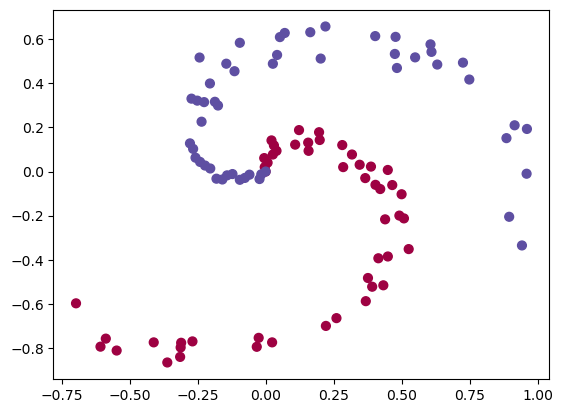

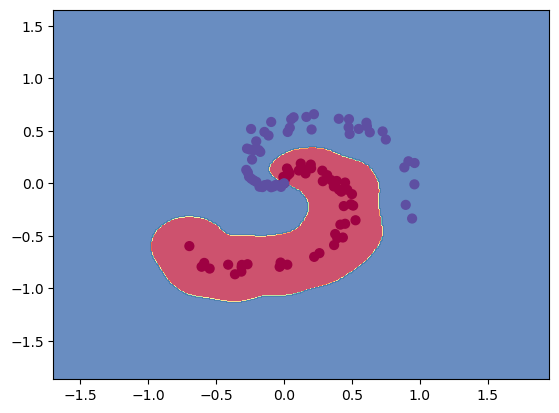

Accuracy: 0.99


In [6]:
np.random.seed(81)
X, y = create_dataset(N=50)

svm = SVM(kernel=gaussian)
svm.fit(X, y)
y_pred = svm.predict(X)
plot_classification_contour(X, y, svm)

print(f"The mode Accuracy is: {sum(y==y_pred)/y.shape[0]}")